<h2><font color="gray">Prepared by: Muhammet Eren KÜÇÜK</font></h2>



<h1 style="color: firebrick; font-family: verdana"><b>Employee Attrition Prediction</b></h1>

<h2 style="font-family: verdana"><b>1.1: Problem Definition</b></h2>

<p style="font-family: verdana">For this part of our assignment, we've been provided with a dataset that consists of 1470 employees. Each employee has information of <b>34 discrete and continuous attributes</b> regarding one's age, distance from home, department field, education etc. and <b>two class type ground-truth outputs.</b> (Attrition: ”Yes” or ”No”)</p>

<p style="font-family: verdana">The objective of this part is to understand and be familiar with the decision tree algorithm. We'll experiment with the <b>decision tree model (by using ID3 algorithm)</b> on the Employee Attrition Prediction dataset. With our model, we'll predict whether an employee has a potential attrition (voluntary or forced cease of work) or not.</p>

<p style="font-family: verdana">These will be performed by using <b>5-fold cross validation method</b>. Within the scope of our decision tree model, we'll implement the ID3 algorithm on discrete values. For continuous values, we'll convert them to discrete values for our ID3 algorithm implementation. Then we'll calculate the <b>accuracy, precision, recall and F1 score</b> values for our model. Using these values, we'll decide upon the best decision tree model to use with minimal errors.</p>

<h2 style="font-family: verdana"><b>1.2: Reading Data and Discretization of Continuous Values</b></h2>

<p style="font-family: verdana">First; we need to import the necessary libraries for parsing the dataset, performing the intermediate array operations and creating our models with the dataset. Pandas will only be used for reading the CSV file to gather data.</p>

In [1]:
from math import e, log
from numpy import array
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

<p style="font-family: verdana">First, we have to read the CSV file with Pandas. After reading the values we need, we have to designate the "Attrition" column as the last column, to use the remaining columns in our decision tree model. After that, we defined the columns' IDs and names to be used later. Finally, we converted our dataframe to a Numpy array and shuffled it.</p>

In [2]:
# read the csv file with pandas
# we use pandas only here
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
# get columns to change Attrition column place to last place
cols = df.columns.tolist()
cols = cols[0:1] + cols[2:] + cols[1:2]
df = df[cols]
# get columns names
column_names = list(df)
# get column ids (0,34)
column_id = np.array(range(0, len(column_names)))
# make dataframe to numpy array
df = df.to_numpy()
# shuffle dataframe
np.random.shuffle(df)

<p style="font-family: verdana">As mentioned in the Problem Definition section, we'll implement an ID3 algorithm of our own to be used in discrete values. Since some values in our dataset are continuous, we have to discretize them with a function. Our function's implementation basically depends on specifying some intervals from the minimum and maximum values of the respective attributes' columns. As a value to be used in splitting the columns into intervals, we chose <b>5</b>. After writing our function, we call it for the columns that have continuous values, so in the end all of our values will be specified as discrete.</p>

In [3]:
def cont2disc(data, col_idx):
    max_value = data[:, col_idx].max()
    min_value = data[:, col_idx].min()
    min_interval = data[:, col_idx].min()
    column_range = []
    while min_interval <= max_value:
        column_range.append(int(min_interval))
        min_interval += (max_value - min_value) / 5
    for k in range(len(data[:, col_idx])):
        for i in range(len(column_range) - 1):
            if column_range[i + 1] >= data[:, col_idx][k] >= column_range[i]:
                data[:, col_idx][k] = i + 1
    return data


# makes continuous features to discrete with their indexes
# We firstly make Age column which has index 0 to discrete.
df = cont2disc(df, 0)
df = cont2disc(df, 2)
df = cont2disc(df, 4)
df = cont2disc(df, 5)
df = cont2disc(df, 8)
df = cont2disc(df, 9)
df = cont2disc(df, 11)
df = cont2disc(df, 12)
df = cont2disc(df, 13)
df = cont2disc(df, 15)
df = cont2disc(df, 17)
df = cont2disc(df, 18)
df = cont2disc(df, 19)
df = cont2disc(df, 22)
df = cont2disc(df, 23)
df = cont2disc(df, 24)
df = cont2disc(df, 26)
df = cont2disc(df, 27)
df = cont2disc(df, 28)
df = cont2disc(df, 29)
df = cont2disc(df, 30)
df = cont2disc(df, 31)
df = cont2disc(df, 32)
df = cont2disc(df, 33)

<h2 style="font-family: verdana"><b>1.3: Entropy and Information Gain Calculations</b></h2>

<p style="font-family: verdana">In a given dataset, our goal is to find <b>the best gain</b> value to be used for our ID3 algorithm, which is dependent on the <b>entropy</b> of data.</p>

<p style="font-family: verdana"><b>Entropy</b> basically specifies how much variance our data has (or how polarized our data is). The more random values we have, the higher our entropy is.</p>

<p style="font-family: verdana"><b>Gain</b> deals with the best split value to be used inside data. To choose the best split value, we have to select a value such that the data will be randomized the least (aka. for which split value, our data will be varied the least?). We've already defined the data's randomness with entropy, so we have to pick a value that will minimize entropy of our data. In short, gain is <b>the deduction of entropy</b>.</p>

In [4]:
# calculate entropy to use when we find best gain for ID3
# when the entropy is high. we can say that distribution is polarized
def entropy(data, base=None):
    attrition_column = data[:, -1]
    n_attrition = len(attrition_column)
    if n_attrition <= 1:
        return 0
    value, counts = np.unique(attrition_column, return_counts=True)
    probs = counts / n_attrition
    n_classes = np.count_nonzero(probs)
    if n_classes <= 1:
        return 0
    ent = 0.
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)
    return ent

<p style="font-family: verdana">Our gain function will take the column responding to the given column ID and the data that includes the values to gain. It will return the best split value for our column data to be used in ID3, by using the entropy information.</p>

In [5]:
# calculate information gain to use for ID3
# the function take dataset and col_id as parameter
# return best_gain_key as index for example 0 index 0 is Age
def calc_information_gain(data, col_ids):
    gains = {}
    for id in col_ids:
        values = [item for item, count in Counter(data[:, id]).items()]
        counts = [count for item, count in Counter(data[:, id]).items()]
        all_entropy = entropy(data)
        for i in range(len(values)):
            value_data = data[data[:, id] == values[i]]
            value_entropy = entropy(value_data)
            all_entropy -= (counts[i] / len(data[:, id])) * value_entropy
        gain = all_entropy
        gains[id] = gain
    best_gain_key = max(gains, key=gains.get)
    return best_gain_key

<h2 style="font-family: verdana"><b>1.4: Implementing ID3 Decision Tree Algorithm</b></h2>

<p style="font-family: verdana">To be used for our ID3 algorithm, we'll specify a Node class to be used for the decision tree. A Node object will have <b>children Nodes, value, column name, rule, attribute name and attribute ID</b>.</p>

In [6]:
# A normal Node class
# which has children, values, rule, attribute_name and id features.
class Node:
    def __init__(self, attr_id, attr_name, values, rule):
        self.children = []
        self.values = values
        self.rule = rule
        self.attr_name = attr_name
        self.attr_id = attr_id

<p style="font-family: verdana">To be used for our model, we'll also specify an <b>attribution dictionary</b>, which will contain the dataframe values and headers.</p>

In [7]:
# An attribution dict
# The dict contains dataframe values and headers
# we make the attribution dict to apply to the model
attr_dict = {'Age': array([1, 2, 3, 4, 5, 60], dtype=object), 'BusinessTravel': array(['Non-Travel', 'Travel_Frequently', 'Travel_Rarely'],
      dtype=object), 'DailyRate': array([1, 2, 3, 4, 5], dtype=object), 'Department': array(['Human Resources', 'Research & Development', 'Sales'],
      dtype=object), 'DistanceFromHome': array([1, 2, 3, 4, 5], dtype=object), 'Education': array([5],
      dtype=object), 'EducationField': array(['Human Resources', 'Life Sciences', 'Marketing', 'Medical','Other', 'Technical Degree'],
      dtype=object), 'EmployeeCount': array([1], dtype=object), 'EmployeeNumber': array([1, 2, 3, 4, 5],
      dtype=object), 'EnvironmentSatisfaction': array([5], dtype=object), 'Gender': array(['Female', 'Male'], dtype=object), 'HourlyRate': array([1, 2, 3, 4, 5],
      dtype=object), 'JobInvolvement': array([5], dtype=object), 'JobLevel': array([5],
      dtype=object), 'JobRole': array(['Healthcare Representative', 'Human Resources','Laboratory Technician', 'Manager', 'Manufacturing Director','Research Director', 'Research Scientist', 'Sales Executive','Sales Representative'],
      dtype=object), 'JobSatisfaction': array([5], dtype=object), 'MaritalStatus': array(['Divorced', 'Married', 'Single'],
      dtype=object), 'MonthlyIncome': array([1, 2, 3, 4, 5], dtype=object), 'MonthlyRate': array([1, 2, 3, 4, 5], dtype=object), 'NumCompaniesWorked': array([2, 3, 4, 5],
      dtype=object), 'Over18': array(['Y'], dtype=object), 'OverTime': array(['No', 'Yes'], dtype=object), 'PercentSalaryHike': array([1, 2, 3, 4, 23, 24, 25],
      dtype=object), 'PerformanceRating': array([1, 4], dtype=object), 'RelationshipSatisfaction': array([5], dtype=object), 'StandardHours': array([80],
      dtype=object), 'StockOptionLevel': array([4, 5], dtype=object), 'TotalWorkingYears': array([1, 2, 3, 4, 5], dtype=object), 'TrainingTimesLastYear': array([5],
      dtype=object), 'WorkLifeBalance': array([5], dtype=object), 'YearsAtCompany': array([1, 2, 3, 4, 5], dtype=object), 'YearsInCurrentRole': array([1, 2, 3, 4, 5],
      dtype=object), 'YearsSinceLastPromotion': array([1, 2, 3, 4, 5], dtype=object), 'YearsWithCurrManager': array([1, 2, 3, 4, 5], dtype=object), 'Attrition': array(['No', 'Yes'],
      dtype=object)}

<p style="font-family: verdana">ID3 arranges all the attributes in a way that the attribute that has the highest gain value would be placed closer to the root node. At first, we'll figure out which attribute has the highest gain. Then, we'll designate it as the parent node of the current level. This node will have the same amount of child nodes as the amount of possible values for that node, each node representing a decision regarding the parent node.</p>

<p style="font-family: verdana">One thing to note is that not all parent roots need to spawn child nodes after the gain calculations. We'll always compare the attribute we'll get to the ground-truth outputs. If it's not possible to get multiple outputs for an attribute in the data, we'll only write one child node which contains the decision instead of the attribute, and that node will be a leaf node.</p>

In [8]:
# ID3 decision tree algorithm
def ID3(data, attr_ids, rule):
    # All of the attributes in the attribute ids list have their GAIN values computed,
    # and the calculated ones are taken out of the list.
    # The variable with the greatest GAIN value is designated as the new LEAF when the list is entirely empty.
    if (len(attr_ids[:-1]) == 0):
        targets = [item for item, count in Counter(df[:, -1]).items()]
        counts = [count for item, count in Counter(df[:, -1]).items()]
        index, value = 0, counts[0]
        for i, v in enumerate(counts):
            if v > value:
                index, value = i, v
        rules = str(rule) + targets[index]
        print(rules)
        return Node(-1, column_names[-1], targets[index], rules)

    #  returns leaf node yes, no. when everything is ok.
    if (len(set(data[:, -1])) == 1):
        b = Counter(data[:, -1])
        common_check = b.most_common(1)[0][0]
        rules = str(rule) + common_check
        print(rules)
        return Node(-1, column_names[-1], common_check, rules)

    # best information gain values and best information gain value index
    best_val_idx = calc_information_gain(data, attr_ids[:-1])

    # the best attribute's potential values
    possible_vals = attr_dict[column_names[best_val_idx]]

    # creating node of tree ID3
    child_node = Node(best_val_idx, column_names[best_val_idx], possible_vals, rule)
    child_node.rule += column_names[best_val_idx] + " ==> "

    # print all combination of node and child nodes
    for values in possible_vals:
        val_data = data[np.where(data[:, best_val_idx] == values)[0]]
        if val_data.shape[0] != 0:
            attr_idx_list = []
            for i in attr_ids:
                if i == best_val_idx:
                    continue
                else:
                    attr_idx_list.append(i)
            rules = str(child_node.rule) + str(values) + " ^ "
            child_node.children.append(ID3(val_data, attr_idx_list, rules))
        else:
            targets = [item for item, count in Counter(df[:, -1]).items()]
            counts = [count for item, count in Counter(df[:, -1]).items()]
            index, value = 0, counts[0]
            for i, v in enumerate(counts):
                if v > value:
                    index, value = i, v
            rules = str(child_node.rule) + str(values) + " ^ " + targets[index]
            print(rules)
            child_node.children.append(Node(-1, column_names[-1], targets[index], rules))

    return child_node

<h2 style="font-family: verdana"><b>1.5: 5-fold Cross Validation, Splitting Data and Calculations</b></h2>

<p style="font-family: verdana">Our prediction function will take a specified row and tree. It will calculate the values for a specified node associated with the attribute in the tree until the "Attrition" attributes' decision nodes are reached. The values in the decision nodes will be returned.</p>

In [9]:
def predict(node, row):
    node.attr_name = ""
    while node.attr_name != "Attrition":
        vals_list = []
        for i in range(len(node.values)):
            if node.values[i] == row[node.attr_id]:
                vals_list.append(i)
        next_node = node.children[vals_list[0]]
        node = next_node
        if node.attr_name == "Attrition":
            return node.values

<p style="font-family: verdana">From here, this section will entirely be concerned with ready-made libraries for the necessary operations regarding the error analysis. After splitting our dataframe with 5-fold cross validation applied, we'll receive train and test data for our predictions. Then, we'll prepare a decision tree and make our predictions using the tree and the test data. For each prediction, we'll append the result <b>(which will either return "Yes" or "No")</b> to a predictions list. The accuracy, precision, recall and F1 score values will be calculated after the predictions are compared with the actual ground-truth outputs in the data.</p>

In [10]:
k_fold = KFold(n_splits=5)
fold_value = 0
mis_predict = []
mis_test_data = []
mis_train_data = []

for train_index, test_index in k_fold.split(df):
    train_data = df[train_index]
    test_data = df[test_index]
    mis_test_data = test_data
    mis_train_data = train_data
    tree = ID3(train_data, column_id, "")
    predicts = []
    for row in test_data:
        x = predict(tree, row)
        predicts.append(x)
    mis_predict = predicts
    fold_value += 1
    tn, fp, fn, tp = confusion_matrix(test_data[:, -1], predicts, labels=["Yes", "No"]).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)  # accuracy
    prec = tp / (tp + fp)  # precision
    recall = tp / (tp + fn)  # recall
    f1score = 2 * (recall * prec) / (recall + prec)  # f1score
    print("Accuracy for fold ", fold_value, " is ", acc)
    print("Precision for fold ", fold_value, " is ", prec)
    print("Recall for fold ", fold_value, " is ", recall)
    print("F1 Score for fold ", fold_value, " is ", f1score)

JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 1 ^ NumCompaniesWorked ==> 2 ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 1 ^ NumCompaniesWorked ==> 3 ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 1 ^ NumCompaniesWorked ==> 4 ^ BusinessTravel ==> Non-Travel ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 1 ^ NumCompaniesWorked ==> 4 ^ BusinessTravel ==> Travel_Frequently ^ Yes
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 1 ^ NumCompaniesWorked ==> 4 ^ BusinessTravel ==> Travel_Rarely ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 1 ^ NumCompaniesWorked ==> 5 ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 2 ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 3 ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 4 ^ DailyRate ==> 1 ^ BusinessTravel ==> Non-Travel ^ No
JobRole ==> Healthcare Representative ^ DistanceFromHome ==> 4 ^ Dail

JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 1 ^ MonthlyRate ==> 5 ^ DailyRate ==> 1 ^ No
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 1 ^ MonthlyRate ==> 5 ^ DailyRate ==> 2 ^ Yes
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 1 ^ MonthlyRate ==> 5 ^ DailyRate ==> 3 ^ No
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 1 ^ MonthlyRate ==> 5 ^ DailyRate ==> 4 ^ No
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 1 ^ MonthlyRate ==> 5 ^ DailyRate ==> 5 ^ Yes
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 2 ^ MaritalStatus ==> Divorced ^ No
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 2 ^ MaritalStatus ==> Married ^ NumCompaniesWorked ==> 2 ^ BusinessTravel ==> Non-Travel ^ Yes
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 2 ^ MaritalStatus ==> Married ^ NumCompaniesWorked ==> 2 ^ BusinessTravel ==> Travel_Frequently ^ No
JobRole ==> Research Scientist ^ OverTime ==> Yes ^ Age ==> 2

OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStatus ==> Divorced ^ HourlyRate ==> 1 ^ DistanceFromHome ==> 1 ^ No
OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStatus ==> Divorced ^ HourlyRate ==> 1 ^ DistanceFromHome ==> 2 ^ Yes
OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStatus ==> Divorced ^ HourlyRate ==> 1 ^ DistanceFromHome ==> 3 ^ Yes
OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStatus ==> Divorced ^ HourlyRate ==> 1 ^ DistanceFromHome ==> 4 ^ Yes
OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStatus ==> Divorced ^ HourlyRate ==> 1 ^ DistanceFromHome ==> 5 ^ No
OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStatus ==> Divorced ^ HourlyRate ==> 2 ^ BusinessTravel ==> Non-Travel ^ No
OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStatus ==> Divorced ^ HourlyRate ==> 2 ^ BusinessTravel ==> Travel_Frequently ^ Yes
OverTime ==> No ^ JobRole ==> Laboratory Technician ^ MaritalStat

OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 1 ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 2 ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 3 ^ MaritalStatus ==> Divorced ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 3 ^ MaritalStatus ==> Married ^ Yes
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 3 ^ MaritalStatus ==> Single ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 4 ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 5 ^ EducationField ==> Human Resources ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 5 ^ EducationField ==> Life Sciences ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 5 ^ EducationField ==> Marketing ^ Yes
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 5 ^ EducationField ==> Medical ^ Yes
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 5 ^ EducationField ==> Other ^ No
OverTime ==> Yes ^ JobRole ==> Manager ^ DailyRate ==> 5 ^ EducationFiel

JobRole ==> Laboratory Technician ^ OverTime ==> No ^ Age ==> 5 ^ EmployeeNumber ==> 1 ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> No ^ Age ==> 5 ^ EmployeeNumber ==> 2 ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> No ^ Age ==> 5 ^ EmployeeNumber ==> 3 ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> No ^ Age ==> 5 ^ EmployeeNumber ==> 4 ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> No ^ Age ==> 5 ^ EmployeeNumber ==> 5 ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> No ^ Age ==> 60 ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ TotalWorkingYears ==> 1 ^ MonthlyRate ==> 1 ^ BusinessTravel ==> Non-Travel ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ TotalWorkingYears ==> 1 ^ MonthlyRate ==> 1 ^ BusinessTravel ==> Travel_Frequently ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ TotalWorkingYears ==> 1 ^ MonthlyRate ==> 1 ^ BusinessTravel ==> Travel_Rarely ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Y

JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 1 ^ EmployeeNumber ==> 1 ^ Yes
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 1 ^ EmployeeNumber ==> 2 ^ No
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 1 ^ EmployeeNumber ==> 3 ^ No
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 1 ^ EmployeeNumber ==> 4 ^ No
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 1 ^ EmployeeNumber ==> 5 ^ No
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 2 ^ EmployeeNumber ==> 1 ^ No
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 2 ^ EmployeeNumber ==> 2 ^ No
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ DistanceFromHome ==> 1 ^ DailyRate ==> 2 ^ EmployeeNumber ==> 3 ^ Yes
JobRole ==> Sales Executive ^ OverTime ==> Yes ^ Dista

JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 2 ^ Age ==> 1 ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 2 ^ Age ==> 2 ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 2 ^ Age ==> 3 ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 2 ^ Age ==> 4 ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 2 ^ Age ==> 5 ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 2 ^ Age ==> 60 ^ No
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 3 ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 4 ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 23 ^ BusinessTravel ==> Non-Travel ^ Yes
JobRole ==> Laboratory Technician ^ OverTime ==> Yes ^ PercentSalaryHike ==> 23 ^ BusinessTravel ==> Travel_Frequently ^ No
JobRole

JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate ==> 2 ^ EmployeeNumber ==> 1 ^ Age ==> 1 ^ No
JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate ==> 2 ^ EmployeeNumber ==> 1 ^ Age ==> 2 ^ Yes
JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate ==> 2 ^ EmployeeNumber ==> 1 ^ Age ==> 3 ^ No
JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate ==> 2 ^ EmployeeNumber ==> 1 ^ Age ==> 4 ^ No
JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate ==> 2 ^ EmployeeNumber ==> 1 ^ Age ==> 5 ^ No
JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate ==> 2 ^ EmployeeNumber ==> 1 ^ Age ==> 60 ^ No
JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate ==> 2 ^ EmployeeNumber ==> 2 ^ No
JobRole ==> Sales Executive ^ OverTime ==> No ^ NumCompaniesWorked ==> 3 ^ HourlyRate 

JobRole ==> Manager ^ OverTime ==> Yes ^ DailyRate ==> 5 ^ Age ==> 1 ^ No
JobRole ==> Manager ^ OverTime ==> Yes ^ DailyRate ==> 5 ^ Age ==> 2 ^ Yes
JobRole ==> Manager ^ OverTime ==> Yes ^ DailyRate ==> 5 ^ Age ==> 3 ^ No
JobRole ==> Manager ^ OverTime ==> Yes ^ DailyRate ==> 5 ^ Age ==> 4 ^ Yes
JobRole ==> Manager ^ OverTime ==> Yes ^ DailyRate ==> 5 ^ Age ==> 5 ^ No
JobRole ==> Manager ^ OverTime ==> Yes ^ DailyRate ==> 5 ^ Age ==> 60 ^ No
JobRole ==> Manufacturing Director ^ EmployeeNumber ==> 1 ^ TotalWorkingYears ==> 1 ^ DailyRate ==> 1 ^ No
JobRole ==> Manufacturing Director ^ EmployeeNumber ==> 1 ^ TotalWorkingYears ==> 1 ^ DailyRate ==> 2 ^ Yes
JobRole ==> Manufacturing Director ^ EmployeeNumber ==> 1 ^ TotalWorkingYears ==> 1 ^ DailyRate ==> 3 ^ No
JobRole ==> Manufacturing Director ^ EmployeeNumber ==> 1 ^ TotalWorkingYears ==> 1 ^ DailyRate ==> 4 ^ No
JobRole ==> Manufacturing Director ^ EmployeeNumber ==> 1 ^ TotalWorkingYears ==> 1 ^ DailyRate ==> 5 ^ No
JobRole ==> Manuf

JobRole ==> Sales Representative ^ BusinessTravel ==> Travel_Rarely ^ YearsInCurrentRole ==> 1 ^ PercentSalaryHike ==> 3 ^ DailyRate ==> 1 ^ No
JobRole ==> Sales Representative ^ BusinessTravel ==> Travel_Rarely ^ YearsInCurrentRole ==> 1 ^ PercentSalaryHike ==> 3 ^ DailyRate ==> 2 ^ No
JobRole ==> Sales Representative ^ BusinessTravel ==> Travel_Rarely ^ YearsInCurrentRole ==> 1 ^ PercentSalaryHike ==> 3 ^ DailyRate ==> 3 ^ Yes
JobRole ==> Sales Representative ^ BusinessTravel ==> Travel_Rarely ^ YearsInCurrentRole ==> 1 ^ PercentSalaryHike ==> 3 ^ DailyRate ==> 4 ^ No
JobRole ==> Sales Representative ^ BusinessTravel ==> Travel_Rarely ^ YearsInCurrentRole ==> 1 ^ PercentSalaryHike ==> 3 ^ DailyRate ==> 5 ^ No
JobRole ==> Sales Representative ^ BusinessTravel ==> Travel_Rarely ^ YearsInCurrentRole ==> 1 ^ PercentSalaryHike ==> 4 ^ DailyRate ==> 1 ^ No
JobRole ==> Sales Representative ^ BusinessTravel ==> Travel_Rarely ^ YearsInCurrentRole ==> 1 ^ PercentSalaryHike ==> 4 ^ DailyRate ==

<p style="font-family: verdana">Receiving misclassified examples is likely inevitable when working with ID3. Here, when a predicted Attrition value doesn't match with the Attrition value present inside the test data, it will be denoted as misclassified.</p>

<p style="font-family: verdana">When we look at the samples, we can see that the features are quite similar. This means that the misclassification is present due to <b>overfitting</b>, which is a common problem with decision tree algorithms such as ID3. There are several approaches to this issue and the one that's utilized the most for ID3 is <b>pruning</b>, which will be the focus of this assignment's Part II.</p>

In [11]:
print("--------- MISCLASSIFIED EXAMPLES ---------")

i = 0
while i < len(mis_test_data):
    if mis_predict[i] != mis_test_data[i, -1]:
        print(mis_test_data[i, :])
    i += 1

--------- MISCLASSIFIED EXAMPLES ---------
[2 'Travel_Frequently' 2 'Research & Development' 1 5 'Technical Degree' 1
 1 5 'Male' 3 5 5 'Manufacturing Director' 5 'Married' 1 2 3 'Y' 'No' 3 1
 5 80 4 1 5 5 1 1 1 1 'No']
[1 'Travel_Rarely' 3 'Research & Development' 1 5 'Medical' 1 1 5 'Male' 3
 5 5 'Research Scientist' 5 'Married' 1 1 2 'Y' 'Yes' 2 1 5 80 4 1 5 5 1 1
 1 1 'Yes']
[1 'Non-Travel' 2 'Research & Development' 2 5 'Medical' 1 4 5 'Female' 5
 5 5 'Research Scientist' 5 'Single' 1 1 2 'Y' 'Yes' 25 4 5 80 4 1 5 5 1 1
 1 1 'Yes']
[1 'Travel_Rarely' 1 'Research & Development' 1 5 'Medical' 1 5 5 'Female'
 2 5 5 'Laboratory Technician' 5 'Single' 1 3 2 'Y' 'No' 1 1 5 80 4 1 5 5
 1 1 1 1 'No']
[1 'Travel_Rarely' 4 'Research & Development' 1 5 'Life Sciences' 1 2 5
 'Female' 3 5 5 'Laboratory Technician' 5 'Married' 1 4 2 'Y' 'Yes' 1 1 5
 80 4 1 5 5 1 1 1 1 'No']
[2 'Travel_Frequently' 4 'Human Resources' 4 5 'Human Resources' 1 2 5
 'Female' 1 5 5 'Human Resources' 5 'Divorced' 3 2

<h2 style="font-family: verdana"><b>1.6: Error Analysis for Classification and Conclusion</b></h2>

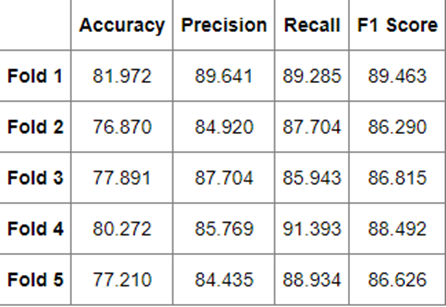

<p style="font-family: verdana"><b>Accuracy:</b> In our table, the accuracy values are in the <b>0.78-0.82</b> interval, which means that for all k values for our 5-fold cross validation, the difference between our accuracies is no more than 0.04. This indicates that our predictions are barely affected by different k values.</p>

<p style="font-family: verdana"><b>Precision:</b> We can see that the precision values are in the <b>0.84-0.91</b> interval. A precision value that's closer to 1 means the model is more reliable. Despite the fact that our model isn't close to being an almost-flawless one, these values are also acceptable for now.</p>

<p style="font-family: verdana"><b>Recall:</b> Our calculated recall values for all folds are in thes <b>0.85-0.93</b> interval. Recall means the percentage of true positive predictions to actual positive values. This means that a good percentage of our true positive predictions are correct.</p>

<p style="font-family: verdana"><b>F1 Score:</b> This value indicates the evenly-distribution amount of data by calculating the harmonic mean of recall and precision values. We don't want to utilize data that are less evenly-distributed than others, so we have to check which folds hold the best F1 score values. In our case, these values are <b>1 and 4</b>.</p>

<p style="font-family: verdana">By looking at this table; we can observe Fold 1 presents a more <b>accurate</b> prediction of true positives and negatives, a more <b>precise</b> prediction of true positives among all positives and a more <b>evenly-distributed</b> data by using recall and precision values, represented as the F1 score. Fold 4 has higher recall, which means that the prediction of true positives among all true positives and false negatives is higher. Fold 1's recall value is quite close to Fold 4 and Fold 1 has higher results in the remaining calculations, so we can say <b>Fold 1</b> has the best model compared to the other folds. Fold 4 is a close second, though it's low precision value makes this model inefficient in finding true positives among all positives.</p>